<a href="https://colab.research.google.com/github/Arifuzzamanjoy/Audio-File-Converter-Organizer/blob/main/flux.1-schnell_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/black-forest-labs/FLUX.1-schnell/resolve/main/flux1-schnell.safetensors -d /content/TotoroUI/models/unet -o flux1-schnell.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-schnell.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Counting objects: 100% (2642/2642), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 14652 (delta 2549), reused 2463 (delta 2463), pack-reused 12010 (from 1)
Receiving objects: 100% (14652/14652), 22.89 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (9901/9901), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

6499140818782689524


  0%|          | 0/4 [00:00<?, ?it/s]

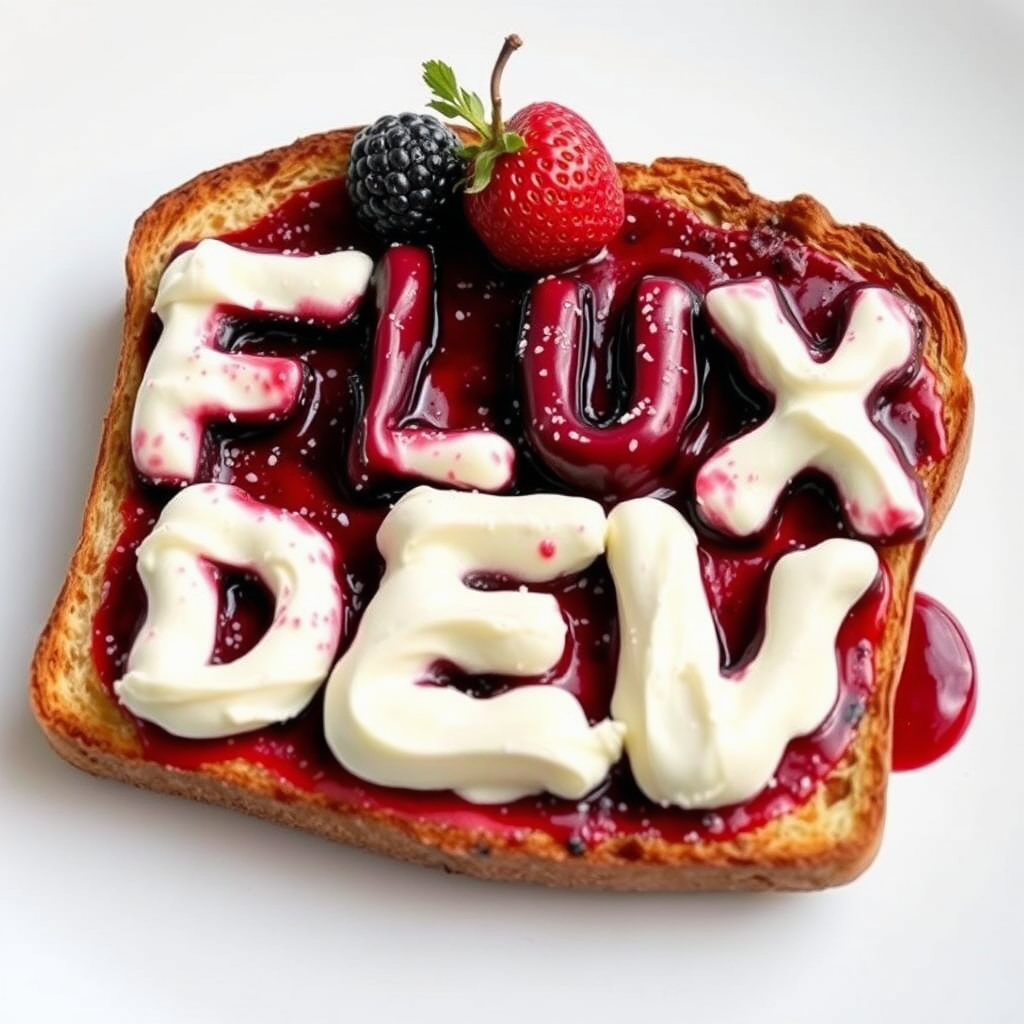

In [2]:
with torch.inference_mode():
    positive_prompt = "black forest toast spelling out the words 'FLUX DEV', tasty, food photography, dynamic shot"
    width = 1024
    height = 1024
    seed = 0
    steps = 4
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

In [9]:
import torch
import random
import json
import os
from PIL import Image
import numpy as np
import itertools

def extract_image_attributes(image_metadata):
    composition_attributes = {
        'body_coverage': 'full-body',
        'head_visibility': True,
        'feet_visibility': True,
        'background_type': 'flat',
        'background_style': 'clean',
        'photography_style': 'commercial editorial'
    }
    return composition_attributes

def update_prompt_with_attributes(base_prompt, attributes):
    attribute_descriptions = [
        f"{attributes['body_coverage']} pose",
        f"head full body and feet fully visible",
        f"{attributes['background_style']} {attributes['background_type']} background",
        f"{attributes['photography_style']} aesthetic"
    ]
    enhanced_prompt = f"{base_prompt}, {', '.join(attribute_descriptions)}"
    return enhanced_prompt

def create_optimized_prompt(params, image_metadata=None):
    base_prompt = (
        f"Generate super realistic full-body portrait of a {params['ethnicity']} {params['gender']}, {params['age'].split('-')[0]} years old, standing upright with head and feet visible, "
        f"{params['hair_color']} hair, wearing {params['style']} clothing "
        f"{params['shot_type'].lower()} shot with {params['angle'].lower()} view, "
        f"studio lighting {params['lighting_conditions']}, clean, depthless, ultra white brightest background, "
        f"commercial, editorial photography style,ghost mannequin compatible, focus on the single person. {params['prompt']}"
    ).strip()

    if image_metadata:
        attributes = extract_image_attributes(image_metadata)
        base_prompt = update_prompt_with_attributes(base_prompt, attributes)

    max_length = 77
    '''
    tokens = tokenizer.tokenize(base_prompt)
    if len(tokens) > max_length:
        base_prompt = tokenizer.convert_tokens_to_string(tokens[:max_length])
    '''
    return base_prompt

def save_image(image, path):
    image.save(path)

def save_metadata(metadata, path):
    with open(path, 'w') as f:
        json.dump(metadata, f, indent=4)

def generate_images(gender, body_built, age, style, ethnicity, hair_color, prompt, background, lighting_conditions, seed, guidance_scale, num_inference_steps, metadata):
    angles = ["front", "diagonal view", "side profile", "rear view"]
    images = []
    base_metadata = []

    seed = int(seed) if seed else 0

    for angle in angles:
        params = {
            'gender': gender,
            'ethnicity': ethnicity,
            'age': age,
            'style': style,
            'hair_color': hair_color,
            'shot_type': "full body",
            'angle': angle,
            'background': background,
            'lighting_conditions': lighting_conditions,
            'prompt': prompt
        }

        optimized_prompt = create_optimized_prompt(params)
        generator = torch.manual_seed(seed)

        with torch.inference_mode():
            positive_prompt = optimized_prompt
            width = 612
            height = 800
            steps = num_inference_steps
            sampler_name = "euler"
            scheduler = "simple"

            if seed == 0:
                seed = random.randint(0, 18446744073709551615)
            print(seed)

            cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
            cond = [[cond, {"pooled_output": pooled}]]
            noise = RandomNoise.get_noise(seed)[0]
            guider = BasicGuider.get_guider(unet, cond)[0]
            sampler = KSamplerSelect.get_sampler(sampler_name)[0]
            sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
            latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
            sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
            model_management.soft_empty_cache()
            decoded = VAEDecode.decode(vae, sample)[0].detach()
            image = Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

            # Ensure the directory exists
            os.makedirs("generated_images_2", exist_ok=True)
            image_path = f"generated_images_2/{gender}_{body_built}_{age}_{style}_{ethnicity}_{hair_color}_{background}_{lighting_conditions}_{angle}.png"
            image.save(image_path)

        images.append(image)
        base_metadata.append({
            "image_path": image_path,
            "gender": gender,
            "body_built": body_built,
            "age": age,
            "style": style,
            "ethnicity": ethnicity,
            "hair_color": hair_color,
            "background": background,
            "lighting_conditions": lighting_conditions,
            "angle": angle
        })

        if angle in ["diagonal view", "side profile"]:
            flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
            flipped_image_path = f"generated_images_2/{gender}_{body_built}_{age}_{style}_{ethnicity}_{hair_color}_{background}_{lighting_conditions}_{angle}_flipped.png"
            flipped_image.save(flipped_image_path)
            images.append(flipped_image)
            base_metadata.append({
                "image_path": flipped_image_path,
                "gender": gender,
                "body_built": body_built,
                "age": age,
                "style": style,
                "ethnicity": ethnicity,
                "hair_color": hair_color,
                "background": background,
                "lighting_conditions": lighting_conditions,
                "angle": f"{angle}_flipped"
            })

    for img, meta in zip(images, base_metadata):
        metadata.append(meta)

    save_metadata(metadata, "generated_images_2/metadata.json")

    return images

def generate_all_combinations():
    genders = ["Female"]
    body_builts = ["Medium Built"]
    ages = ["20-30"]
    styles = ["Sarees", "Shalwar Kameez", "Kurtas"]
    ethnicities = ["Bangladeshi"]
    hair_colors = ["Black"]
    backgrounds = ["White"]
    lighting_conditions = ["Hard Light"]

    all_combinations = list(itertools.product(
        genders, body_builts, ages, styles, ethnicities, hair_colors, backgrounds, lighting_conditions
    ))

    metadata = []
    for combination in all_combinations:
        gender, body_built, age, style, ethnicity, hair_color, background, lighting_condition = combination
        seed = random.randint(100, 10000000)
        guidance_scale = 4
        num_inference_steps = 4
        prompt = ""

        images = generate_images(
            gender, body_built, age, style, ethnicity, hair_color, prompt, background, lighting_condition,
            seed, guidance_scale, num_inference_steps, metadata
        )
        print(f"Total images generated: {len(metadata)}")

if __name__ == "__main__":
    generate_all_combinations()

6731663


  0%|          | 0/4 [00:00<?, ?it/s]

6731663


  0%|          | 0/4 [00:00<?, ?it/s]

6731663


  0%|          | 0/4 [00:00<?, ?it/s]

6731663


  0%|          | 0/4 [00:00<?, ?it/s]

Total images generated: 6
9013395


  0%|          | 0/4 [00:00<?, ?it/s]

9013395


  0%|          | 0/4 [00:00<?, ?it/s]

9013395


  0%|          | 0/4 [00:00<?, ?it/s]

9013395


  0%|          | 0/4 [00:00<?, ?it/s]

Total images generated: 12
1040927


  0%|          | 0/4 [00:00<?, ?it/s]

1040927


  0%|          | 0/4 [00:00<?, ?it/s]

1040927


  0%|          | 0/4 [00:00<?, ?it/s]

1040927


  0%|          | 0/4 [00:00<?, ?it/s]

Total images generated: 18


In [14]:
!zip -r /content/TotoroUI/generated_images_2.zip /content/TotoroUI/generated_images_2

  adding: content/TotoroUI/generated_images_2/ (stored 0%)
  adding: content/TotoroUI/generated_images_2/Female_Medium Built_30-40_Shalwar Kameez_Bangladeshi_Black_White_Hard Light_rear view.png (deflated 0%)
  adding: content/TotoroUI/generated_images_2/Female_Medium Built_30-40_Sarees_Bangladeshi_Black_White_Hard Light_front.png (deflated 0%)
  adding: content/TotoroUI/generated_images_2/Female_Medium Built_30-40_Sarees_Bangladeshi_Black_White_Hard Light_rear view.png (deflated 0%)
  adding: content/TotoroUI/generated_images_2/Female_Medium Built_30-40_Kurtas_Bangladeshi_Black_White_Hard Light_rear view.png (deflated 0%)
  adding: content/TotoroUI/generated_images_2/Female_Medium Built_30-40_Kurtas_Bangladeshi_Black_White_Hard Light_diagonal view.png (deflated 0%)
  adding: content/TotoroUI/generated_images_2/Female_Medium Built_30-40_Kurtas_Bangladeshi_Black_White_Hard Light_side profile.png (deflated 0%)
  adding: content/TotoroUI/generated_images_2/Female_Medium Built_30-40_Shalwa

In [12]:
!ls /content/TotoroUI/

folder_paths.py     input	       node_helpers.py	totoro
generated_images    latent_preview.py  nodes.py		totoro_extras
generated_images_2  models	       __pycache__


In [15]:
!rm -rf /content/TotoroUI/generated_images_2